# Feature deletion

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import LabelEncoder

In [2]:
df = pd.read_csv('../data/data_cleaned.csv', sep=',')

# encode target variable: 0: dropout, 1: enrolled, 2: graduated
le = LabelEncoder()
df['Target_encoded'] = le.fit_transform(df['Target'])

# Drop 'Target' variable
df.drop('Target', axis = 1, inplace = True)

# Change data types of columns that should be categorical
col = ['Marital_status', 'Application_mode', 'Course', 'Previous_qualification',
       'Mother_qualification', 'Father_qualification', 'Mother_occupation',
       'Father_occupation','Target_encoded']

df[col] = df[col].astype('category')


stud_selected = df.drop(['Nationality', 'International', 'Educational_special_needs','Marital_status', 'Inflation_rate'], axis = 1)  
stud_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 32 columns):
 #   Column                                        Non-Null Count  Dtype   
---  ------                                        --------------  -----   
 0   Application_mode                              4424 non-null   category
 1   Application_order                             4424 non-null   int64   
 2   Course                                        4424 non-null   category
 3   Daytime/evening_attendance                    4424 non-null   int64   
 4   Previous_qualification                        4424 non-null   category
 5   Previous_qualification_grade                  4424 non-null   float64 
 6   Mother_qualification                          4424 non-null   category
 7   Father_qualification                          4424 non-null   category
 8   Mother_occupation                             4424 non-null   category
 9   Father_occupation                             4424 n

# Data splitting

X_train shape: (3539, 31)
X_test shape: (885, 31)
y_train shape: (3539,)
y_test shape: (885,)


C:\Users\Martina\AppData\Local\Temp\ipykernel_7688\957121688.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.assign(Percentage=100 * x['Count'] / x['Count'].sum()))


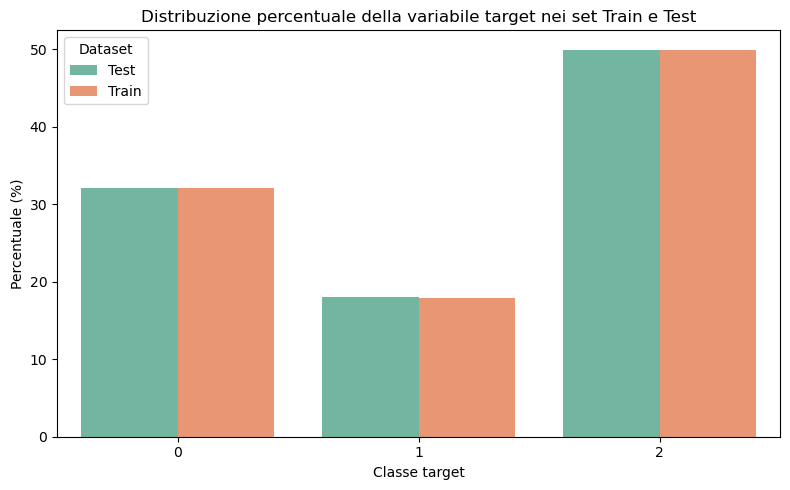

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight

X = stud_selected.drop('Target_encoded', axis=1)  
y = stud_selected['Target_encoded']  

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# === Visualizzazione distribuzione target ===
dist_df = pd.DataFrame({
    'Set': ['Train'] * len(y_train) + ['Test'] * len(y_test),
    'Target': pd.concat([y_train, y_test])
})

percent_df = (
    dist_df.value_counts(['Set', 'Target'])
    .reset_index(name='Count')
    .groupby('Set')
    .apply(lambda x: x.assign(Percentage=100 * x['Count'] / x['Count'].sum()))
    .reset_index(drop=True)
)

# Plot percentuale
plt.figure(figsize=(8, 5))
sns.barplot(data=percent_df, x='Target', y='Percentage', hue='Set', palette='Set2')
plt.title('Distribuzione percentuale della variabile target nei set Train e Test')
plt.xlabel('Classe target')
plt.ylabel('Percentuale (%)')
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()

In [4]:
from collections import Counter

print(Counter(y_train))

Counter({2: 1767, 0: 1137, 1: 635})


# Model comparison

In [5]:
#  Model Comparison for Multi-Class Imbalanced Classification
# ============================================
# Imports
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score, balanced_accuracy_score, roc_auc_score, classification_report
import joblib
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier)
from sklearn.svm import SVC
import sys
import os

sys.path.append(os.path.abspath(os.path.join("..", "utils")))

from FeatTransformer import FeatTransformer
from preprocessing import preprocessor

# Cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Models and refined hyperparameter grids
def get_estimators_and_grids():
    estimators = {
        'decision_tree': DecisionTreeClassifier(random_state=42, class_weight='balanced'),
        'random_forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
        'svm': SVC(probability=True, random_state=42),
        'gradient_boosting': GradientBoostingClassifier(random_state=42),
        'xgboost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        'lightgbm': LGBMClassifier(random_state=42),
        'catboost': CatBoostClassifier(verbose=0, random_state=42, allow_writing_files=False)
    }

    param_grids = {
        'decision_tree': {
            'model__max_depth': [None, 5, 10, 15],
            'model__min_samples_split': [2, 5, 10],
            'model__min_samples_leaf': [1, 2, 4]
        },
        'random_forest': {
            'model__n_estimators': [100, 200, 300],
            'model__max_depth': [None, 10, 20],
            'model__max_features': ['sqrt', 'log2']
        },
        'svm': {
            'model__C': [0.1, 1, 10],
            'model__kernel': ['linear', 'rbf'],
            'model__gamma': ['scale', 'auto']
        },
        'gradient_boosting': {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.01, 0.1],
            'model__max_depth': [3, 5]
        },
        'xgboost': {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.01, 0.1],
            'model__max_depth': [3, 5],
            'model__subsample': [0.8, 1]
        },
        'lightgbm': {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.01, 0.1],
            'model__num_leaves': [31, 50],
            'model__max_depth': [-1, 5]
        },
        'catboost': {
            'model__iterations': [100, 200],
            'model__learning_rate': [0.01, 0.1],
            'model__depth': [6, 10]
        }
    }
    return estimators, param_grids

# Build the imbalanced-learn pipeline
def build_pipeline(model):
    steps = [
        ('feature_transformer', FeatTransformer(drop_originals=True)),
        ('preprocessing', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('model', model)
    ]
    return ImbPipeline(steps)

# Tuning, evaluation, and saving function
def tune_and_evaluate(name, estimator, param_grid):
    print(f"Tuning {name}...")
    pipeline = build_pipeline(estimator)
    search = HalvingGridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=cv,
        scoring='f1_macro',
        factor=2,
        random_state=42,
        verbose=0,
        n_jobs=-1
    )
    search.fit(X_train, y_train)
    best = search.best_estimator_
    print(f"Best params for {name}: {search.best_params_}")

    # Evaluate on test set
    y_pred = best.predict(X_test)
    y_prob = best.predict_proba(X_test)

    metrics = {
        'balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
        'f1_macro': f1_score(y_test, y_pred, average='macro'),
        'roc_auc_macro': roc_auc_score(pd.get_dummies(y_test), y_prob, average='macro')
    }
    report = classification_report(y_test, y_pred, output_dict=True)
    per_class_f1 = {cls: report[cls]['f1-score'] for cls in report if cls not in ['accuracy', 'macro avg', 'weighted avg']}
    metrics['per_class_f1'] = per_class_f1

    # Save best model
    joblib.dump(best, f"../models/best_model_{name}.joblib")
    print(f"Saved best_model_{name}.joblib")

    return metrics, best

In [6]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

estimators, grids = get_estimators_and_grids()
results = {}
for name, estimator in estimators.items():
    metrics, _ = tune_and_evaluate(name, estimator, grids[name])
    results[name] = metrics

# Compile and save results
results_df = pd.DataFrame(results).T
print(results_df)
results_df.to_csv('../results/model_comparison_results_SMOTE.csv')

Tuning decision_tree...


KeyboardInterrupt: 

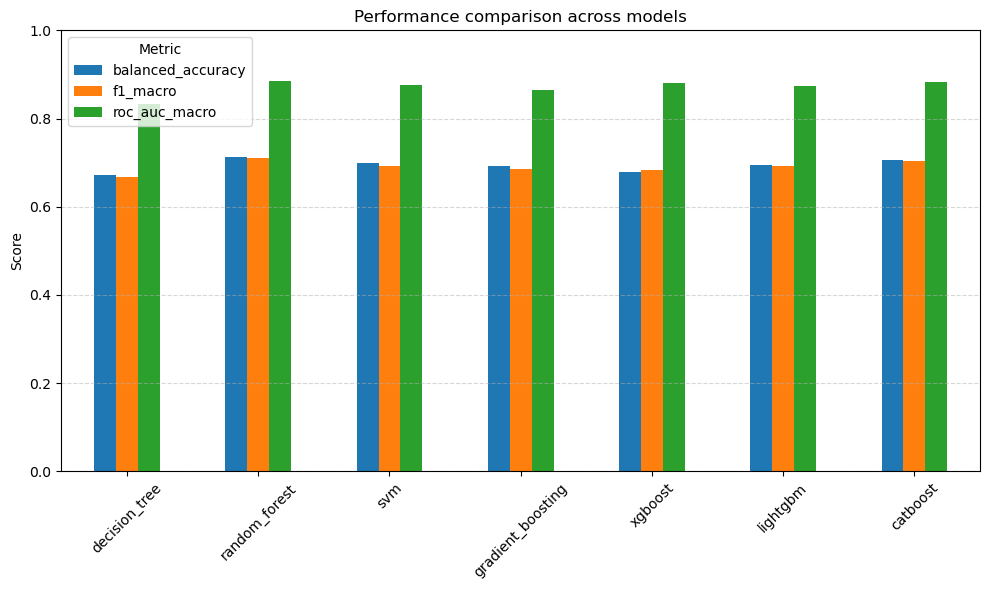

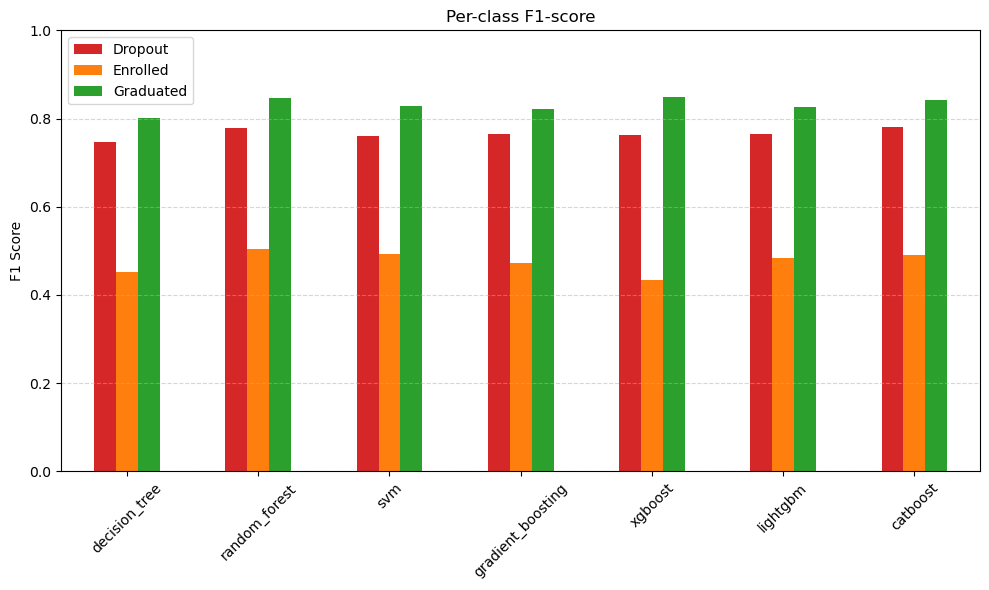

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import ast

df = pd.read_csv("../results/model_comparison_results_SMOTE.csv", index_col=0)


df["per_class_f1"] = df["per_class_f1"].apply(ast.literal_eval)

df["f1_dropout"]   = df["per_class_f1"].apply(lambda d: d.get('0', None))
df["f1_enrolled"]  = df["per_class_f1"].apply(lambda d: d.get('1', None))
df["f1_graduated"] = df["per_class_f1"].apply(lambda d: d.get('2', None))

# === Plot performance comparison across models
metrics = ["balanced_accuracy", "f1_macro", "roc_auc_macro"]
df[metrics].plot(kind="bar", figsize=(10, 6))
plt.title("Performance comparison across models")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.xticks(rotation=45)
plt.legend(title="Metric")
plt.tight_layout()
plt.show()

# === Plot F1 scores per class
df[["f1_dropout", "f1_enrolled", "f1_graduated"]].plot(kind="bar", figsize=(10, 6), color=["#d62728", "#ff7f0e", "#2ca02c"])
plt.title("Per-class F1-score")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.xticks(rotation=45)
plt.legend(["Dropout", "Enrolled", "Graduated"])
plt.tight_layout()
plt.show()


# Statistical comparison RF-CatBoost

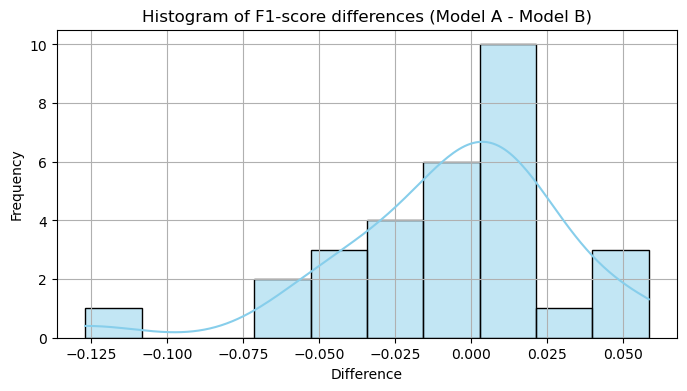

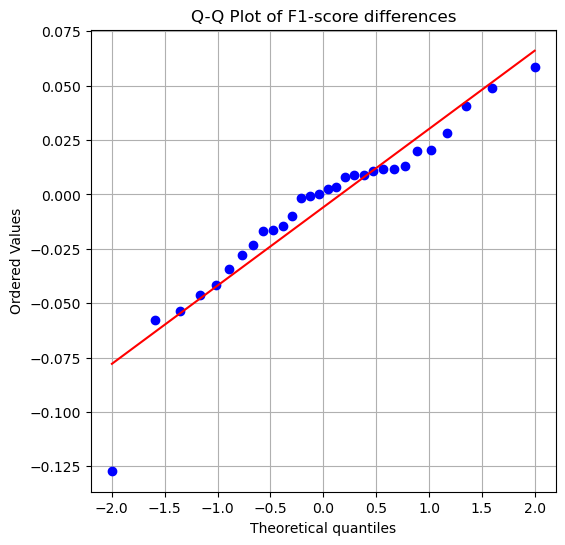

In [ ]:
import numpy as np
import joblib
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from scipy.stats import shapiro
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import RepeatedStratifiedKFold
import sys
import os

sys.path.append(os.path.abspath(os.path.join("..", "utils")))

from FeatTransformer import FeatTransformer
from preprocessing import preprocessor


# === Load the best models ===
model_a = joblib.load("../models/best_model_catboost.joblib")
model_b = joblib.load("../models/best_model_random_forest.joblib")


cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

f1_scores_a = []
f1_scores_b = []

for train_idx, test_idx in cv.split(X_test, y_test):
    X_fold = X_test.iloc[test_idx]
    y_fold = y_test.iloc[test_idx]


    y_pred_a = model_a.predict(X_fold)
    y_pred_b = model_b.predict(X_fold)

    f1_scores_a.append(f1_score(y_fold, y_pred_a, average='macro'))
    f1_scores_b.append(f1_score(y_fold, y_pred_b, average='macro'))

f1_scores_a = np.array(f1_scores_a)
f1_scores_b = np.array(f1_scores_b)

# === Differenze per test statistici ===
diff = f1_scores_a - f1_scores_b


# === Istogramma delle differenze ===
plt.figure(figsize=(8, 4))
sns.histplot(diff, kde=True, bins=10, color='skyblue')
plt.title("Histogram of F1-score differences (Model A - Model B)")
plt.xlabel("Difference")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# === Q-Q plot ===
plt.figure(figsize=(6, 6))
stats.probplot(diff, dist="norm", plot=plt)
plt.title("Q-Q Plot of F1-score differences")
plt.grid(True)
plt.show()




In [9]:
# Perform Shapiro-Wilk test
statistic, p_value = shapiro(diff)

# Print results
print("Shapiro-Wilk Test:")
print(f"Statistic = {statistic:.4f}, p-value = {p_value:.4f}")

Shapiro-Wilk Test:
Statistic = 0.9232, p-value = 0.0324


p-value < 0.05 ---> The data is not normally distributed, and normality cannot be assumed.

In [10]:
from scipy.stats import wilcoxon

w_p_value = wilcoxon(diff)
print('Wilcoxon signed-rank test p-value:', w_p_value)

Wilcoxon signed-rank test p-value: WilcoxonResult(statistic=195.0, pvalue=0.6265970924224259)


The performance difference between the two models is not statistically significant.


# Performance evaluation

In [ ]:
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, classification_report
from sklearn.preprocessing import label_binarize
from sklearn.metrics import RocCurveDisplay
import numpy as np


# ==============================
# Confusion Matrix
# ==============================
def confusion_matrix_plot(y_true, y_pred, classes, name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()


# ==============================
# ROC Curve (One-vs-Rest)
# ==============================
def roc_curve_plot(y_true, y_prob, classes, name):

    y_true_bin = label_binarize(y_true, classes=classes)
    n_classes = y_true_bin.shape[1]

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])


    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f"Class {classes[i]} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - One-vs-Rest ({name})")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()




**Random Forest**


=== Classification Report: Random Forest ===
              precision    recall  f1-score   support

           0     0.8381    0.7289    0.7797       284
           1     0.4632    0.5535    0.5043       159
           2     0.8415    0.8529    0.8472       442

    accuracy                         0.7593       885
   macro avg     0.7142    0.7118    0.7104       885
weighted avg     0.7724    0.7593    0.7639       885

Balanced Accuracy: 0.7118


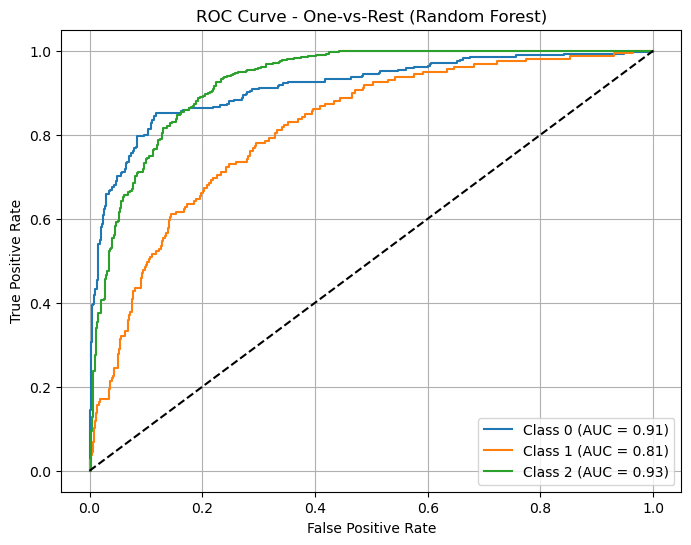

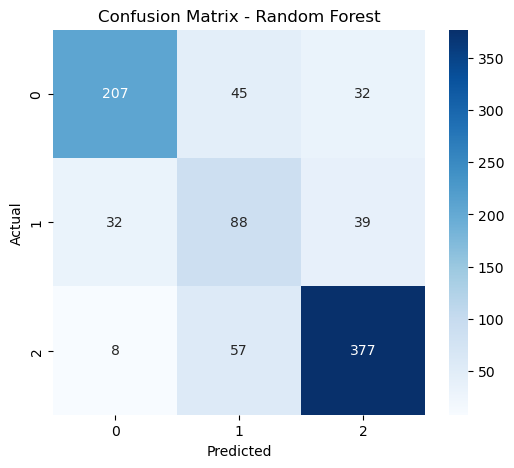

In [16]:
from sklearn.metrics import (
    balanced_accuracy_score, f1_score, roc_auc_score, classification_report
)

model_rf = joblib.load("../models/best_model_random_forest.joblib")

y_pred = model_rf.predict(X_test)
y_prob = model_rf.predict_proba(X_test)


balanced_acc = balanced_accuracy_score(y_test, y_pred)

print("\n=== Classification Report: Random Forest ===")
print(classification_report(y_test, y_pred, digits=4))

print(f"Balanced Accuracy: {balanced_acc:.4f}")

# Plot ROC Curve
roc_curve_plot(y_test, y_prob, model_rf.classes_, "Random Forest")
confusion_matrix_plot(y_test, y_pred, model_rf.classes_, "Random Forest")



**CatBoost**


=== Classification Report: Catboost ===
              precision    recall  f1-score   support

           0     0.8130    0.7500    0.7802       284
           1     0.4611    0.5220    0.4897       159
           2     0.8420    0.8439    0.8429       442

    accuracy                         0.7559       885
   macro avg     0.7054    0.7053    0.7043       885
weighted avg     0.7642    0.7559    0.7593       885

Balanced Accuracy: 0.7053


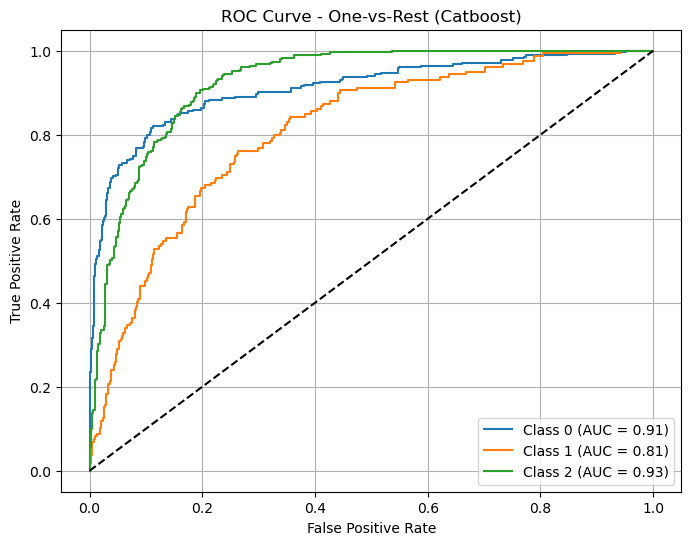

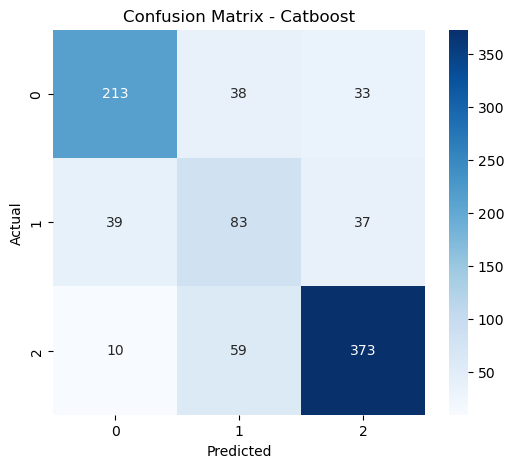

In [12]:
model_cb= joblib.load("../models/best_model_catboost.joblib") 

y_pred = model_cb.predict(X_test)
y_prob = model_cb.predict_proba(X_test)

balanced_acc = balanced_accuracy_score(y_test, y_pred)

print("\n=== Classification Report: Catboost ===")
print(classification_report(y_test, y_pred, digits=4))

print(f"Balanced Accuracy: {balanced_acc:.4f}")

# Plot ROC Curve
roc_curve_plot(y_test, y_prob, model_cb.classes_, "Catboost")
confusion_matrix_plot(y_test, y_pred, model_cb.classes_, "Catboost")

# Model Explainability

## SHAP

In [2]:
import joblib
import sys
import os

sys.path.append(os.path.abspath(os.path.join("..", "utils")))

from FeatTransformer import FeatTransformer
from preprocessing import preprocessor

model_rf = joblib.load("../models/best_model_random_forest.joblib")
model_cb = joblib.load("../models/best_model_catboost.joblib")

In [ ]:
import joblib
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# model = model_cb
model= model_rf

X_test_fe = model.named_steps['feature_transformer'].transform(X_test)
X_test_proc = model.named_steps['preprocessing'].transform(X_test_fe)

if hasattr(X_test_proc, "toarray"):
    X_test_proc = X_test_proc.toarray()


feature_names = model.named_steps['preprocessing'].get_feature_names_out()

X_shap = pd.DataFrame(X_test_proc, columns=feature_names)

model = model.named_steps['model']

# Initialize SHAP explainer and compute SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_shap)



joblib.dump(shap_values, "../shap_output/shap_values_rf.joblib")
joblib.dump(explainer, "../shap_output/shap_explainer_rf.joblib")
X_shap.to_csv("../shap_output/X_shap_rf.csv", index=False)
np.save("../shap_output/feature_names_rf.npy", feature_names)

# joblib.dump(shap_values, "../shap_output/shap_values_cb.joblib")
# joblib.dump(explainer, "../shap_output/shap_explainer_cb.joblib")
# X_shap.to_csv("../shap_output/X_shap_cb.csv", index=False)
# np.save("../shap_output/feature_names_cb.npy", feature_names)




c:\Users\Martina\anaconda3\envs\DMML\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [5]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from collections import defaultdict

# Helper functions for SHAP feature grouping 
def get_group_name(col):
    if col.startswith("oh__"):
        match = re.match(r"oh__([A-Za-z0-9_]+?)_\d+$", col)
        if match:
            return match.group(1)
        else:
            return col.replace("oh__", "")
    elif "__" in col:
        return col.split("__")[1]
    else:
        return col


# Aggregate SHAP values by feature groups
def aggregate_shap(shap_vals_class, X_df, group_map):
    agg_shap = pd.DataFrame(index=X_df.index)
    agg_feat = pd.DataFrame(index=X_df.index)
    for new_feat, orig_feats in group_map.items():
        valid_feats = [f for f in orig_feats if f in X_df.columns]
        if valid_feats:
            feat_indices = [list(X_df.columns).index(f) for f in valid_feats]
            agg_shap[new_feat] = shap_vals_class[:, feat_indices].sum(axis=1)
            agg_feat[new_feat] = X_df[valid_feats].sum(axis=1)
    return agg_shap, agg_feat


# Plot SHAP beeswarm for a specific class
def shap_beeswarm_plot(shap_values, X_df, feature_names, class_name):
    group_map = defaultdict(list)
    for col in feature_names:
        group = get_group_name(col)
        group_map[group].append(col)


    class_names = ["Dropout", "Enrolled", "Graduate"]
    for i, class_name in enumerate(class_names):
        print(f"\n▶️ Generating SHAP beeswarm plot for class: {class_name}")
        shap_vals_i = shap_values[:,:,i] # SHAP values for the i-th class

        # Aggregate SHAP values by feature groups
        agg_shap, agg_feat = aggregate_shap(shap_vals_i, X_shap, group_map)

        # Create SHAP Explanation object
        expl = shap.Explanation(values=agg_shap.values,
                                data=agg_feat.values,
                                feature_names=agg_shap.columns.tolist())
        
        # Beeswarm plot
        plt.figure(figsize=(10, 6))
        shap.plots.beeswarm(expl, max_display=20, show=False)
        plt.title(f"SHAP Beeswarm Plot - Class {class_names[i]}")
        plt.show()


#
def plot_shap_aggregated(shap_values, feature_names, class_names):
    aggregated_shap_class_df = []
    for i in range(3):
        shap_vals = shap_values[:, :, i]  
        shap_df = pd.DataFrame(np.abs(shap_vals), columns=feature_names)
        
        grouped_names = [get_group_name(col) for col in shap_df.columns]
        shap_df.columns = grouped_names

        shap_grouped = shap_df.groupby(shap_df.columns, axis=1).mean()
        shap_importance = shap_grouped.mean().rename(class_names[i])

        aggregated_shap_class_df.append(shap_importance)

    shap_importance_df = pd.concat(aggregated_shap_class_df, axis=1).fillna(0)

    top_features = shap_importance_df.mean(axis=1).sort_values(ascending=False).head(20).index
    shap_top = shap_importance_df.loc[top_features[::-1]]

    shap_top.plot(kind="barh", stacked=True, figsize=(10, 8), color=["#1f77b4", "#bcbd22", "#e377c2"])  
    plt.xlabel("mean(|SHAP value|) (average impact on model output magnitude)")
    plt.title("Multiclass Aggregated SHAP Importance (Grouped Features)")
    plt.legend(title="Class", loc="lower right")
    plt.tight_layout()
    plt.show()

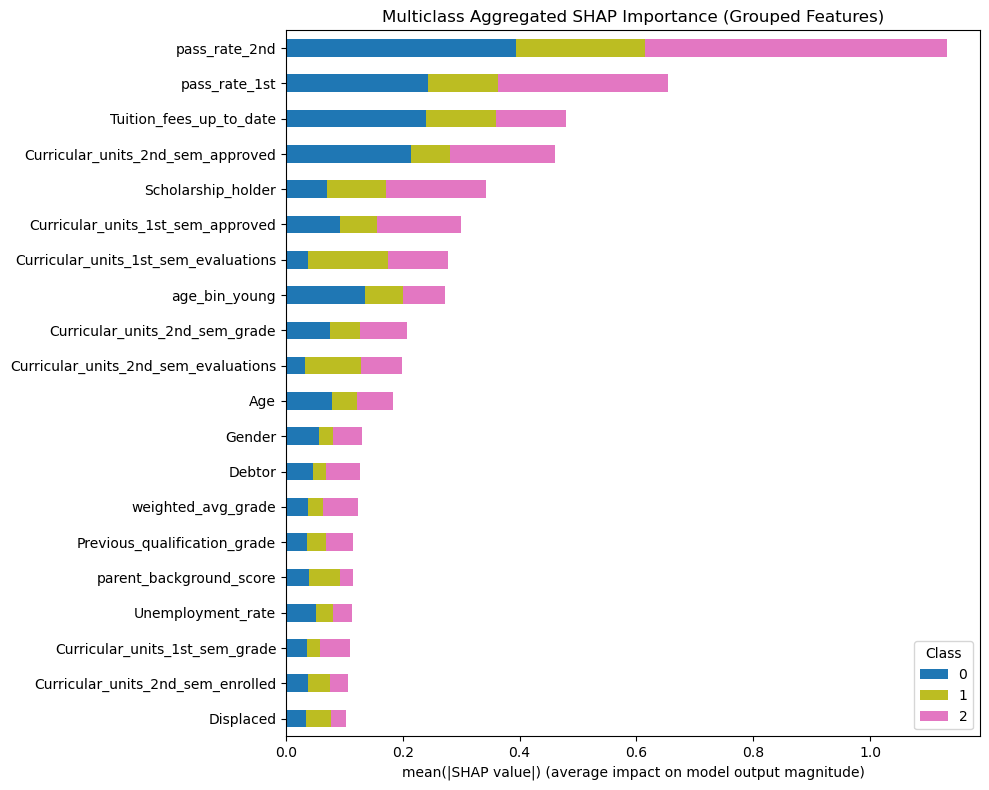


▶️ Generating SHAP beeswarm plot for class: Dropout


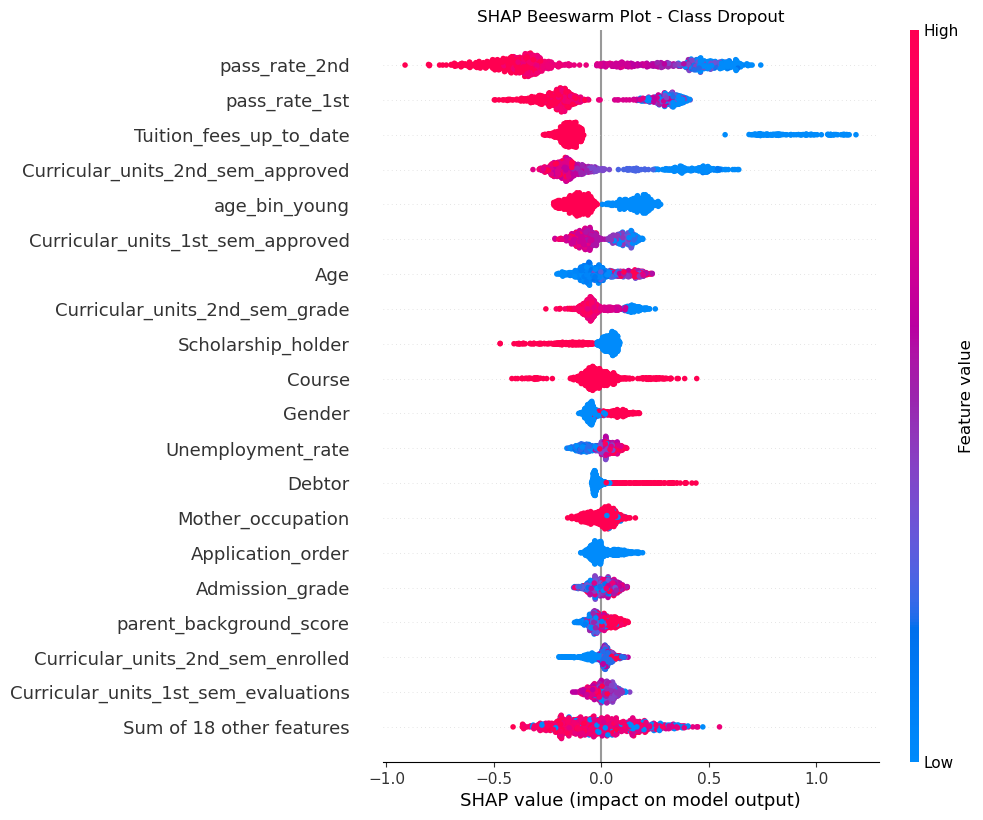


▶️ Generating SHAP beeswarm plot for class: Enrolled


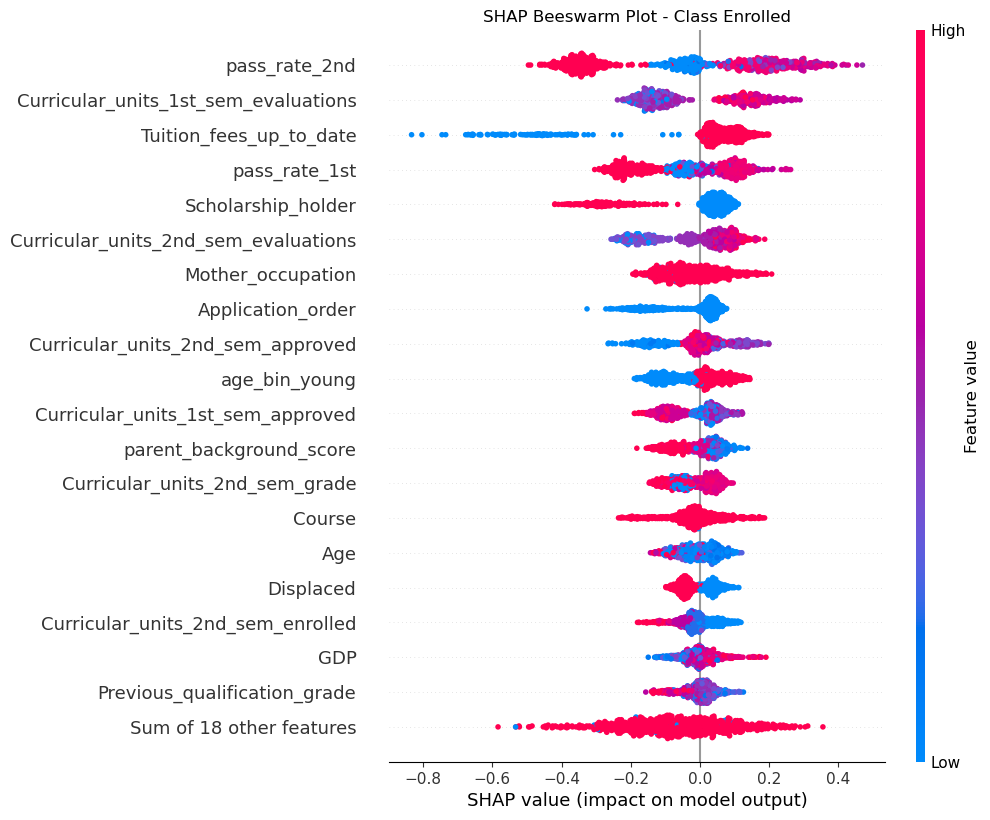


▶️ Generating SHAP beeswarm plot for class: Graduate


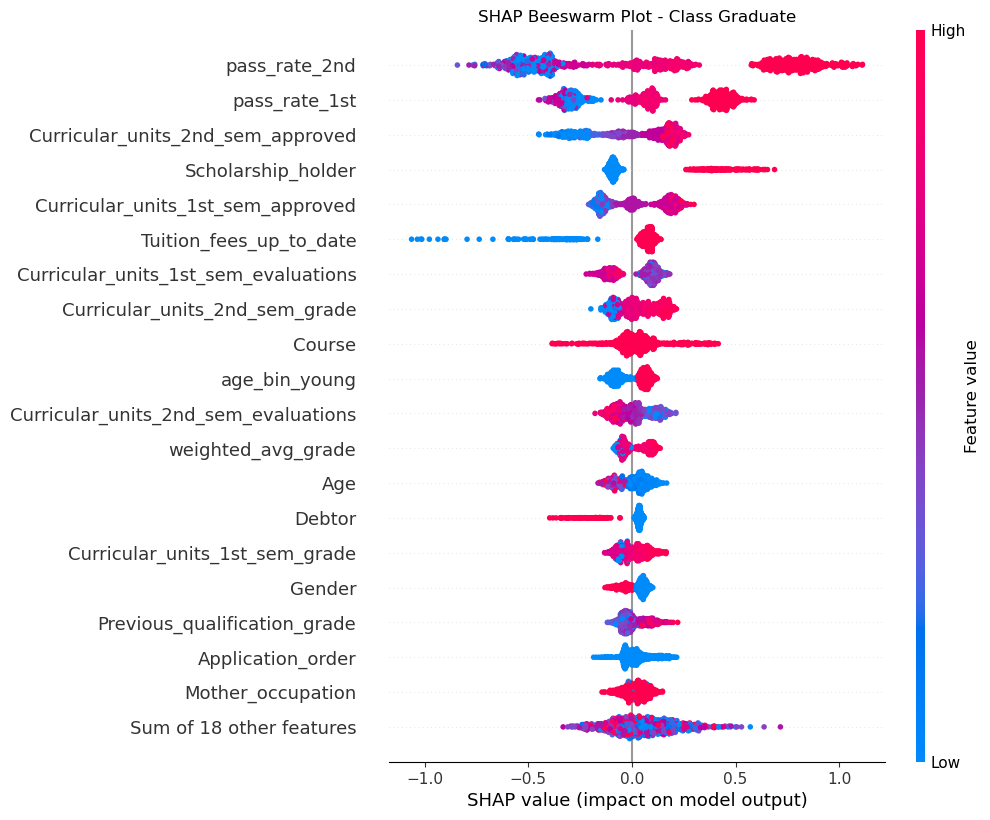

In [14]:
import joblib

#---------------------------------------------
# SHAP values and explainer for Catboost model
#---------------------------------------------

shap_values = joblib.load("../shap_output/shap_values_cb.joblib")
explainer = joblib.load("../shap_output/shap_explainer_cb.joblib")
X_shap = pd.read_csv("../shap_output/X_shap_cb.csv")
feature_names = np.load("../shap_output/feature_names_cb.npy", allow_pickle=True)


plot_shap_aggregated(shap_values, feature_names, model_cb.classes_)
shap_beeswarm_plot(shap_values, X_shap, feature_names, model_cb.classes_)


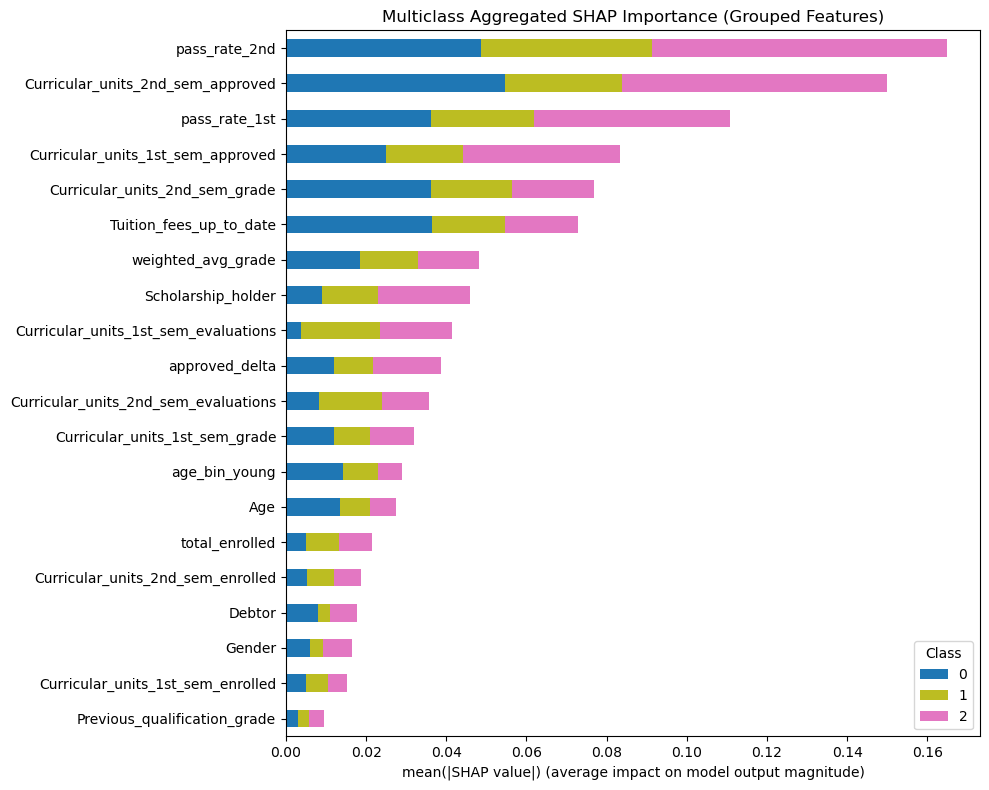


▶️ Generating SHAP beeswarm plot for class: Dropout


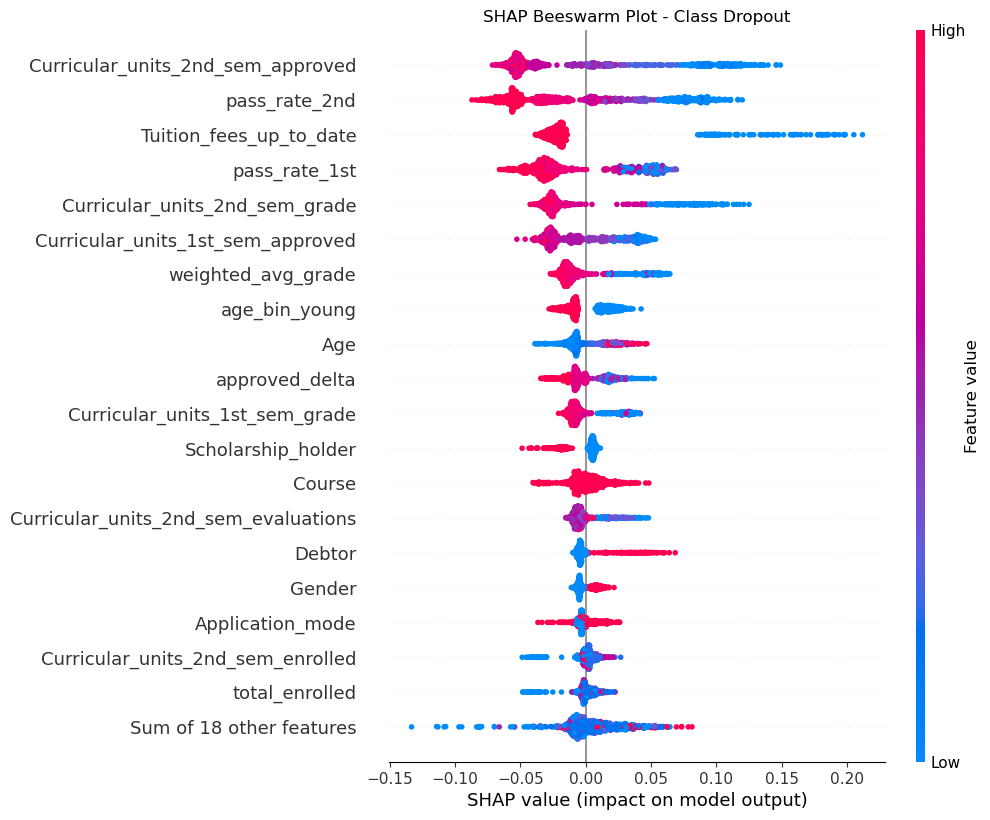


▶️ Generating SHAP beeswarm plot for class: Enrolled


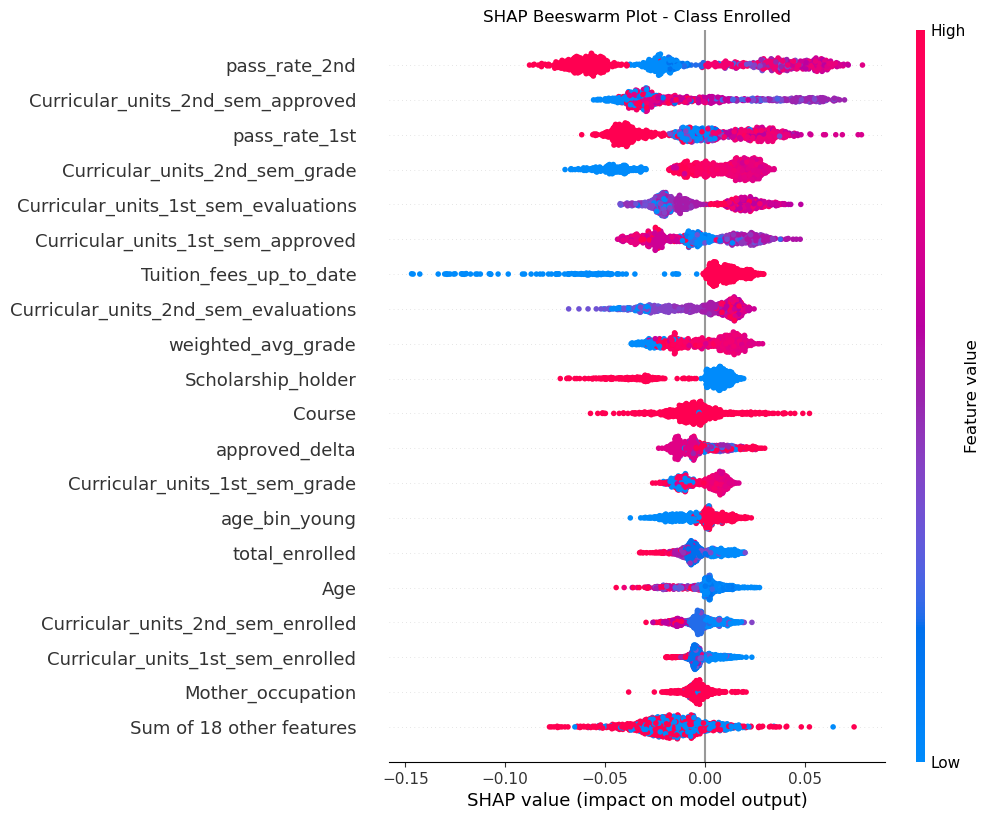


▶️ Generating SHAP beeswarm plot for class: Graduate


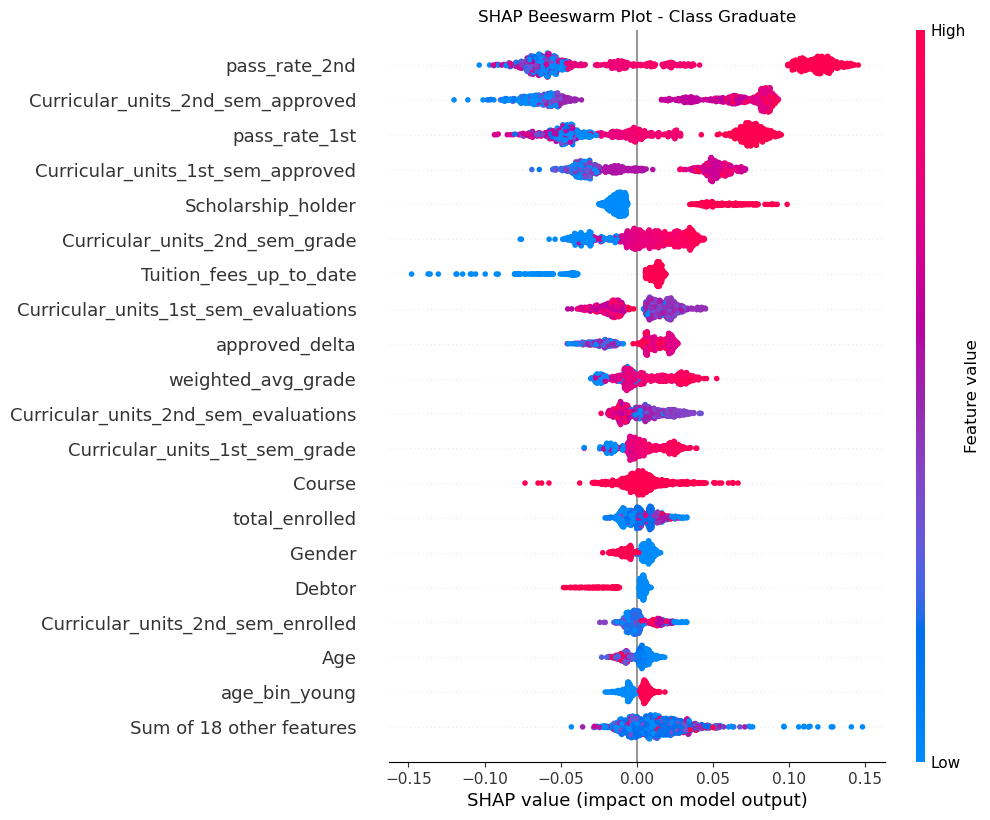

In [17]:
import joblib

#---------------------------------------------
# SHAP values and explainer for Random Forest model
#---------------------------------------------

shap_values = joblib.load("../shap_output/shap_values_rf.joblib")
explainer = joblib.load("../shap_output/shap_explainer_rf.joblib")
X_shap = pd.read_csv("../shap_output/X_shap_rf.csv")
feature_names = np.load("../shap_output/feature_names_rf.npy", allow_pickle=True)

plot_shap_aggregated(shap_values, feature_names, model_rf.classes_)
shap_beeswarm_plot(shap_values, X_shap, feature_names, model_rf.classes_)



**Local Explanations**

In [11]:
import shap
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict



def waterfall_plot(shap_array, explainer, student_index, feature_names, model, X_shap):

    group_map = defaultdict(list)
    for i, col in enumerate(feature_names):
        group = get_group_name(col)
        group_map[group].append(i)

    for class_idx, class_name in enumerate(model.classes_):
        shap_vals = shap_array[student_index, :, class_idx]        
        base_value = explainer.expected_value[class_idx]
        data_vals = X_shap.iloc[student_index].values              

        #eAggregation of SHAP values and data values by feature groups
        aggregated_shap = []
        aggregated_data = []
        grouped_feature_names = []

        for group, indices in group_map.items():
            shap_sum = np.sum([shap_vals[i] for i in indices])
            data_sum = np.sum([data_vals[i] for i in indices])
            aggregated_shap.append(shap_sum)
            aggregated_data.append(data_sum)
            grouped_feature_names.append(group)

        # Create SHAP Explanation object
        explanation = shap.Explanation(
            values=np.array(aggregated_shap),
            base_values=base_value,
            data=np.array(aggregated_data),
            feature_names=grouped_feature_names
        )

        print(f"Waterfall plot for class {class_name}")
        shap.plots.waterfall(explanation, max_display=15, show=False)
        plt.title(f"SHAP Waterfall Plot - Class {class_name}")
        plt.show()

        



In [9]:
import numpy as np

explainer = joblib.load("../shap_output/shap_explainer_cb.joblib")

logits = np.array([explainer.expected_value[0], explainer.expected_value[1], explainer.expected_value[2]])
probs = np.exp(logits) / np.sum(np.exp(logits))

print(probs)


[0.35886564 0.38173853 0.25939583]


Waterfall plot for class 0


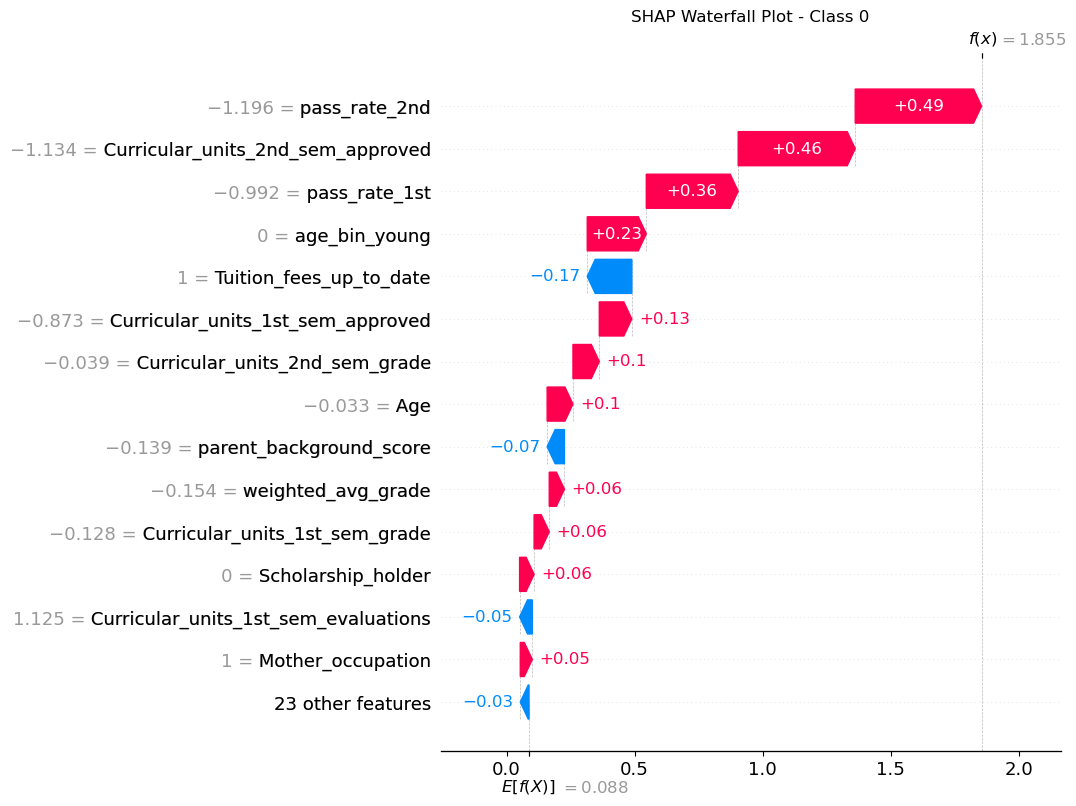

Waterfall plot for class 1


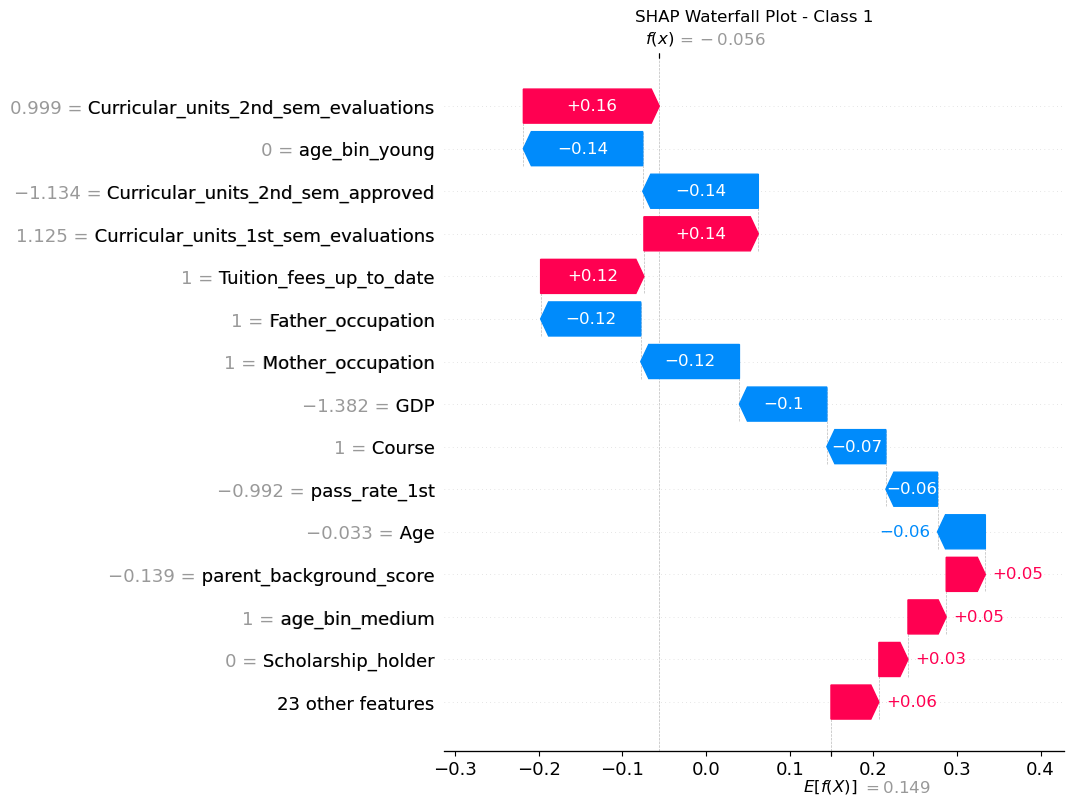

Waterfall plot for class 2


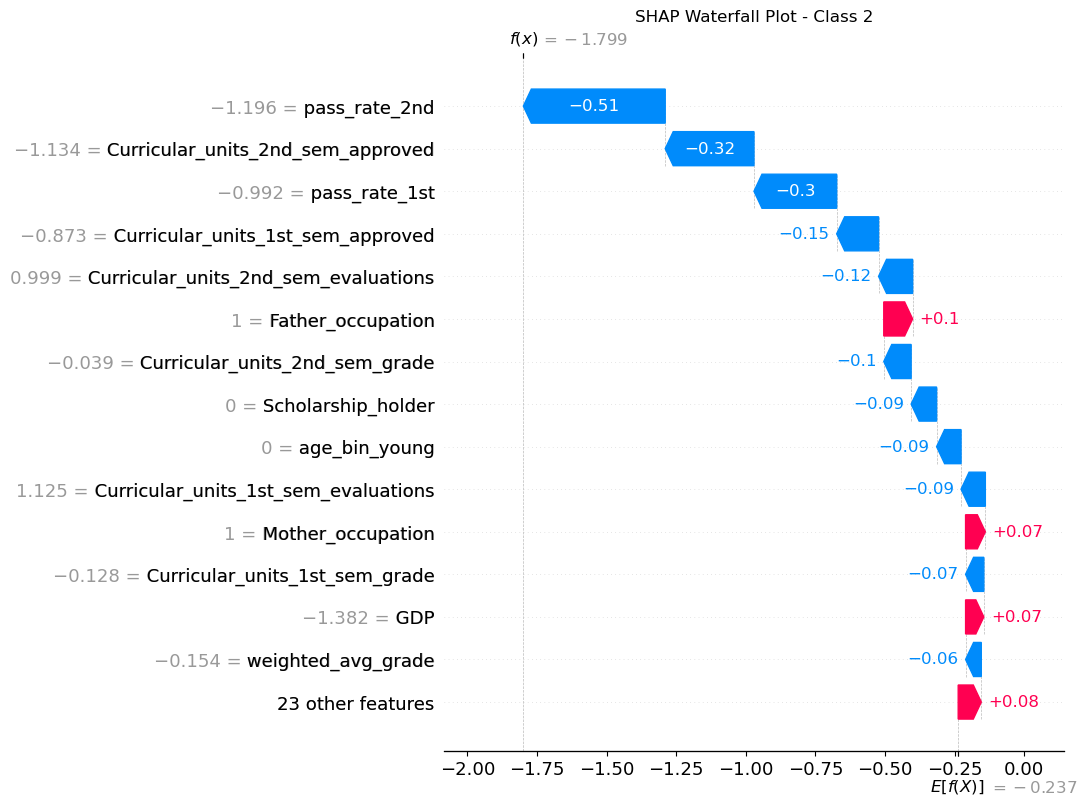

In [17]:
student_index = 90

# Watefall plots for Catboost model

shap_array = joblib.load("../shap_output/shap_values_cb.joblib")  
explainer = joblib.load("../shap_output/shap_explainer_cb.joblib")
X_shap = pd.read_csv("../shap_output/X_shap_cb.csv")
feature_names = np.load("../shap_output/feature_names_cb.npy", allow_pickle=True)

waterfall_plot(shap_array, explainer, student_index, feature_names, model_cb, X_shap)

Waterfall plot for class 0


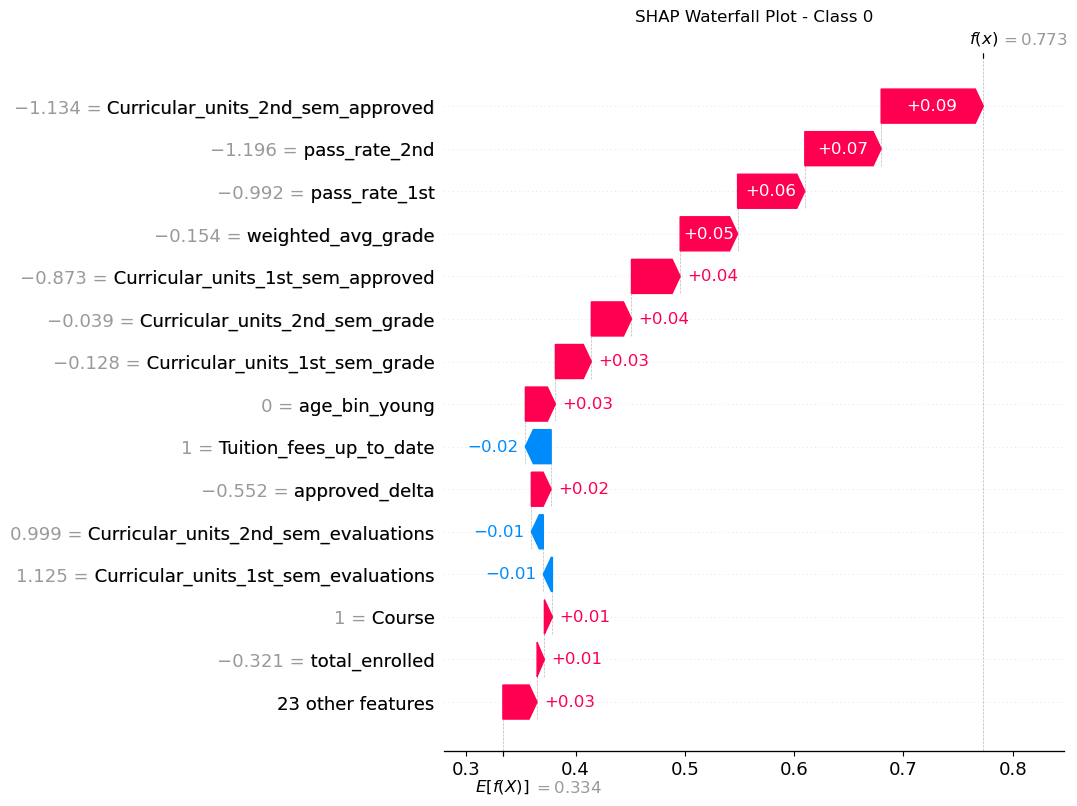

Waterfall plot for class 1


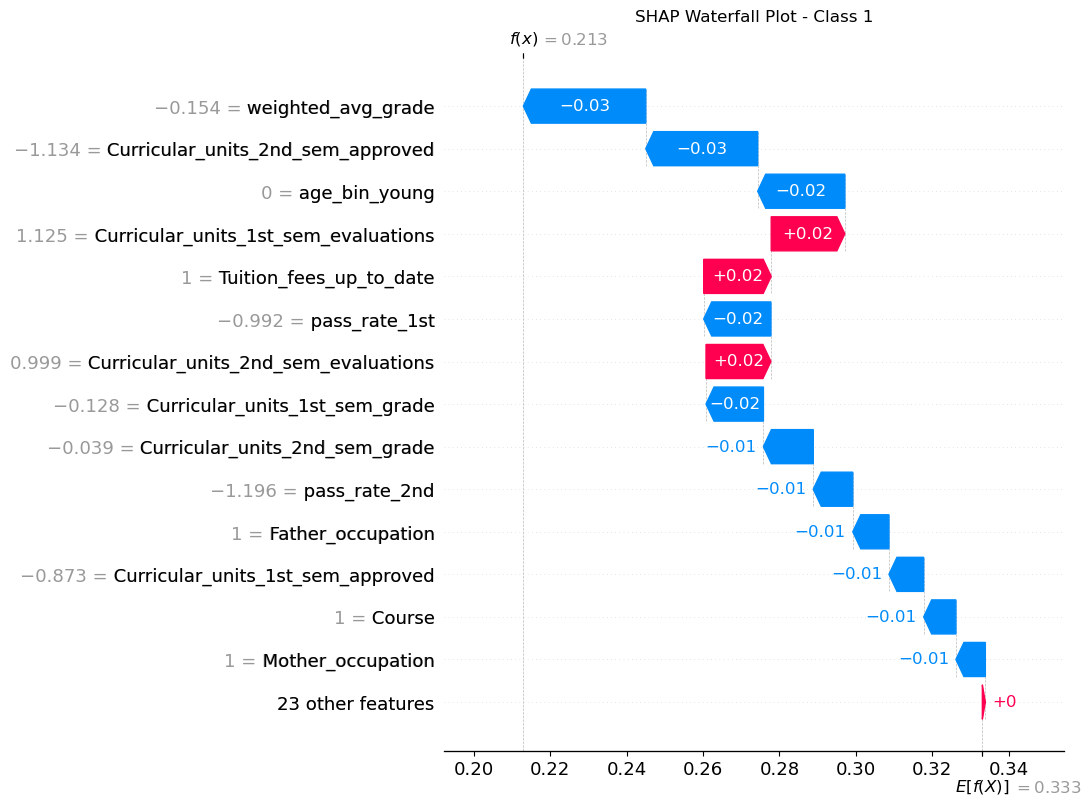

Waterfall plot for class 2


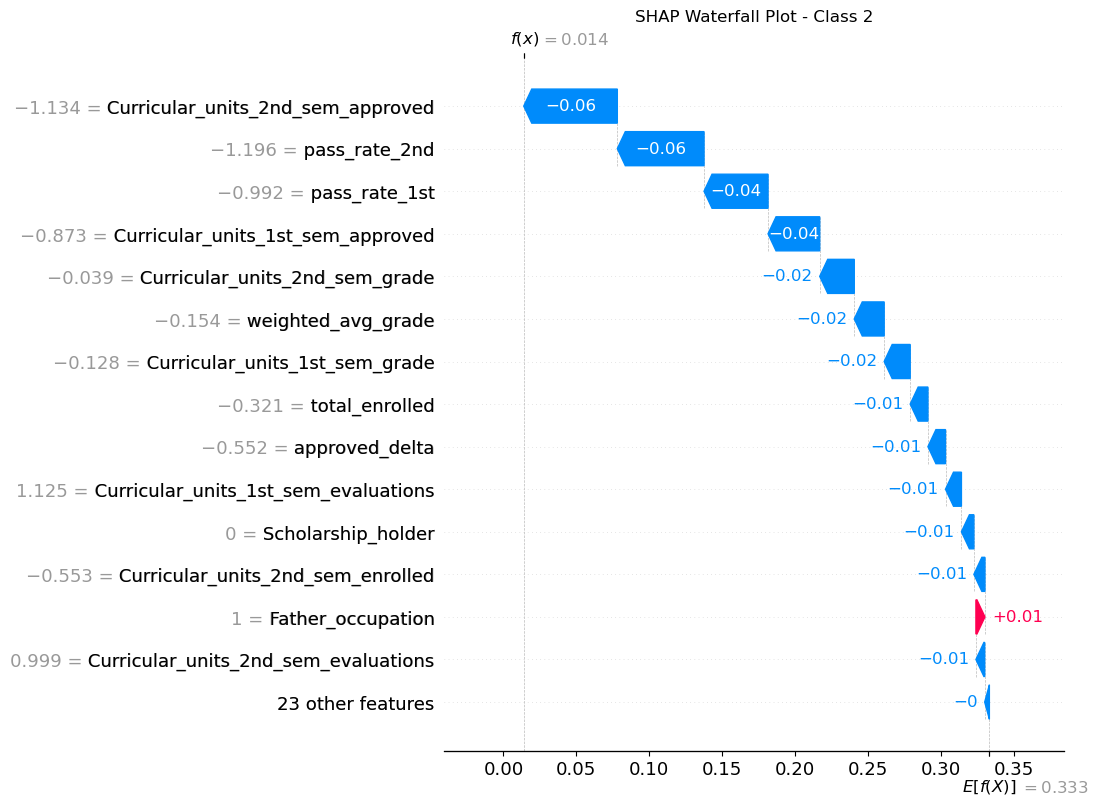

In [ ]:
# Watefall plots for Random Forest model

shap_array = joblib.load("../shap_output/shap_values_rf.joblib")  
explainer = joblib.load("../shap_output/shap_explainer_rf.joblib")
X_shap = pd.read_csv("../shap_output/X_shap_rf.csv")
feature_names = np.load("../shap_output/feature_names_rf.npy", allow_pickle=True)

waterfall_plot(shap_array, explainer, student_index, feature_names, model_rf, X_shap)